#  Notebook 1: Eksploracja Danych - Fruits 360

**Cel**: Poznanie datasetu, wizualizacja przykładowych obrazów, analiza rozkładu klas

---

## Dataset: Fruits 360
- 131 klas owoców i warzyw
- ~90,000 obrazów (100x100px)
- Białe tło, różne kąty obrotu

**Źródło**: https://www.kaggle.com/datasets/moltean/fruits

In [ ]:
# Importy bibliotek
# OpenCV: https://docs.opencv.org/4.x/
# NumPy: https://numpy.org/doc/stable/
# Matplotlib: https://matplotlib.org/stable/contents.html
# Seaborn: https://seaborn.pydata.org/

import os
import sys
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Dodaj src do path
sys.path.append('../src')

# Styling
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Biblioteki załadowane")

✓ Biblioteki załadowane


## 1. Konfiguracja ścieżek

**UWAGA**: Upewnij się, że pobrałeś dataset Fruits 360 i rozpakowałeś go do `data/raw/`

In [ ]:
# Konfiguracja ścieżek do datasetu
# Dataset Fruits 360: https://www.kaggle.com/datasets/moltean/fruits
# Paper: Mureșan & Oltean (2018) - "Fruit recognition from images using deep learning"

# Ścieżki
DATA_DIR = Path('../data/raw/')
TRAIN_DIR = DATA_DIR / 'Training'
TEST_DIR = DATA_DIR / 'Test'

# Sprawdź czy dataset istnieje
if not TRAIN_DIR.exists():
    print("❌ Dataset nie znaleziony!")
    print(f"   Oczekiwana ścieżka: {TRAIN_DIR.absolute()}")
    print("\n📥 Pobierz dataset Fruits 360:")
    print("   1. https://www.kaggle.com/datasets/moltean/fruits")
    print("   2. Rozpakuj do data/raw/")
else:
    print(f"✓ Dataset znaleziony: {TRAIN_DIR.absolute()}")
    print(f"✓ Test set: {TEST_DIR.absolute()}")

✓ Dataset znaleziony: /Users/thomasross/Projects/wsb/multimedia/notebooks/../data/raw/Training
✓ Test set: /Users/thomasross/Projects/wsb/multimedia/notebooks/../data/raw/Test


## 2. Analiza struktury datasetu

In [ ]:
# Analiza struktury datasetu - zliczanie obrazów
# Pathlib docs: https://docs.python.org/3/library/pathlib.html

# Funkcja do zliczania obrazów w każdej klasie
def count_images_per_class(base_dir):
    """Zlicza obrazy w każdej klasie (obsługuje zagnieżdżone podkatalogi)"""
    class_counts = {}
    
    if not base_dir.exists():
        return class_counts
    
    # Iteruj przez kategorie (Apple, Cherry, etc.)
    for category_dir in sorted(base_dir.iterdir()):
        if not category_dir.is_dir() or category_dir.name.startswith('.'):
            continue
            
        # Iteruj przez podklasy (Apple 11, Apple 12, etc.)
        for class_dir in sorted(category_dir.iterdir()):
            if not class_dir.is_dir() or class_dir.name.startswith('.'):
                continue
                
            n_images = len(list(class_dir.glob('*.jpg')))
            if n_images > 0:
                class_counts[class_dir.name] = n_images
    
    return class_counts

# Zlicz obrazy
train_counts = count_images_per_class(TRAIN_DIR)
test_counts = count_images_per_class(TEST_DIR)

if train_counts:
    print(f"📊 Statystyki datasetu:")
    print(f"  Liczba klas: {len(train_counts)}")
    print(f"  Obrazy treningowe: {sum(train_counts.values()):,}")
    print(f"  Obrazy testowe: {sum(test_counts.values()):,}")
    print(f"  Łącznie: {sum(train_counts.values()) + sum(test_counts.values()):,}")
    print(f"\n  Min obrazów na klasę (train): {min(train_counts.values())}")
    print(f"  Max obrazów na klasę (train): {max(train_counts.values())}")
    print(f"  Średnia obrazów na klasę: {np.mean(list(train_counts.values())):.1f}")
else:
    print("⚠️ Brak danych - pobierz dataset!")

📊 Statystyki datasetu:
  Liczba klas: 48
  Obrazy treningowe: 34,800
  Obrazy testowe: 12,233
  Łącznie: 47,033

  Min obrazów na klasę (train): 304
  Max obrazów na klasę (train): 984
  Średnia obrazów na klasę: 725.0


## 3. Wizualizacja rozkładu klas

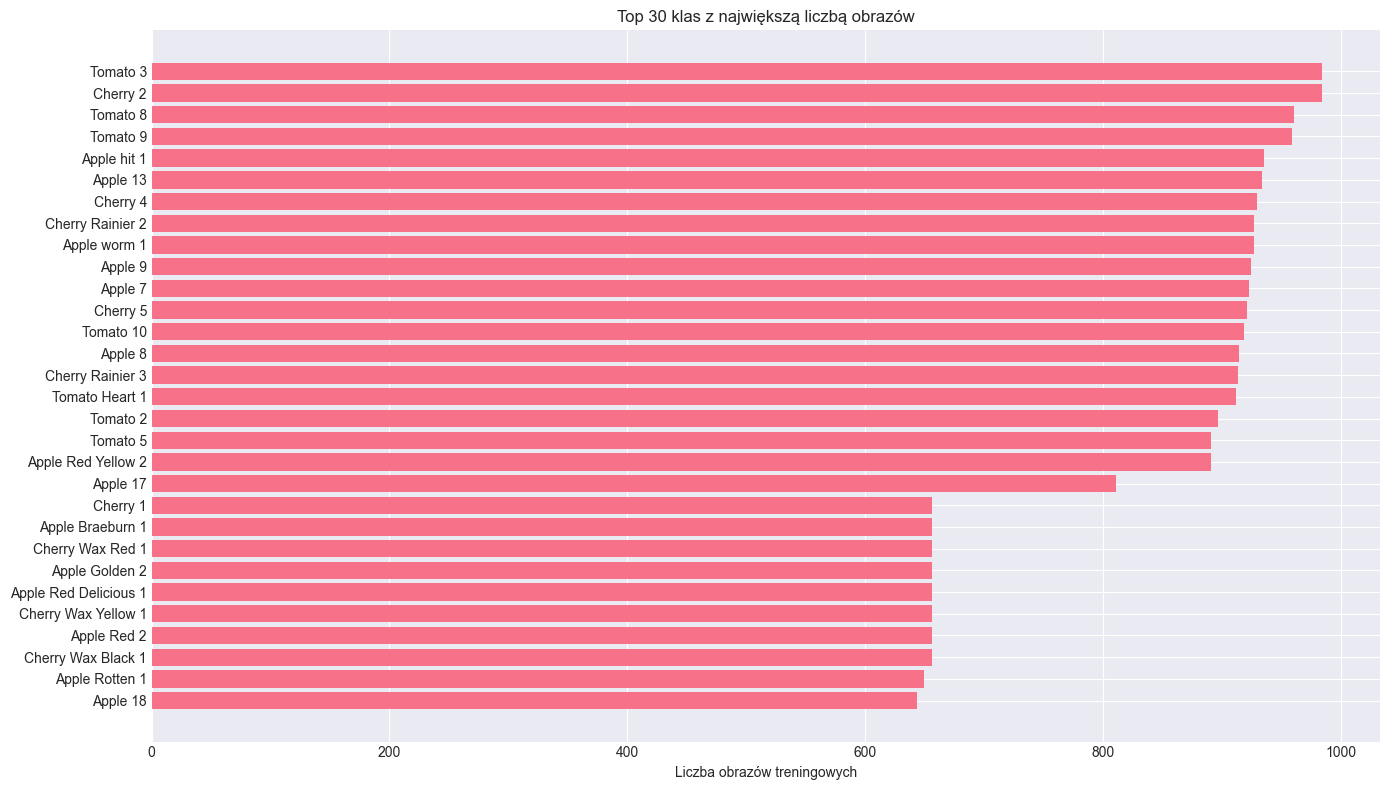

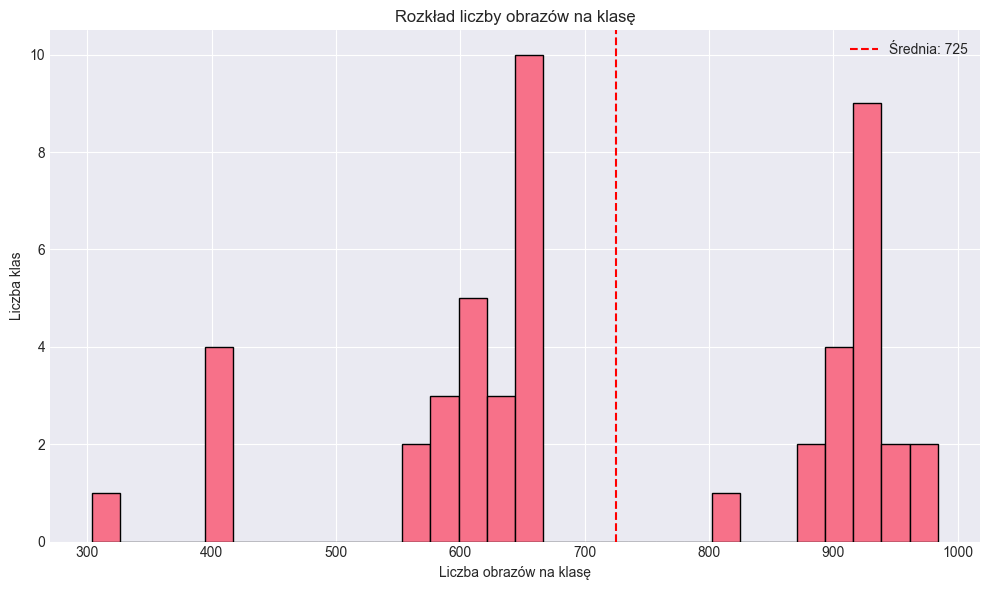

In [ ]:
# Wizualizacja rozkładu klas
# Pandas DataFrame: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html
# Matplotlib pyplot: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html

# Rozkład liczby obrazów na klasę (top 30 klas)
if train_counts:
    df_counts = pd.DataFrame({
        'Klasa': train_counts.keys(),
        'Liczba obrazów': train_counts.values()
    }).sort_values('Liczba obrazów', ascending=False)
    
    # Top 30 klas
    plt.figure(figsize=(14, 8))
    top_30 = df_counts.head(30)
    plt.barh(range(len(top_30)), top_30['Liczba obrazów'].values)
    plt.yticks(range(len(top_30)), top_30['Klasa'].values)
    plt.xlabel('Liczba obrazów treningowych')
    plt.title('Top 30 klas z największą liczbą obrazów')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    # Histogram rozkładu
    plt.figure(figsize=(10, 6))
    plt.hist(df_counts['Liczba obrazów'], bins=30, edgecolor='black')
    plt.xlabel('Liczba obrazów na klasę')
    plt.ylabel('Liczba klas')
    plt.title('Rozkład liczby obrazów na klasę')
    plt.axvline(df_counts['Liczba obrazów'].mean(), color='red', 
                linestyle='--', label=f'Średnia: {df_counts["Liczba obrazów"].mean():.0f}')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Brak danych do wizualizacji")

## 4. Wizualizacja przykładowych obrazów

🖼️ Losowe przykłady z datasetu treningowego:


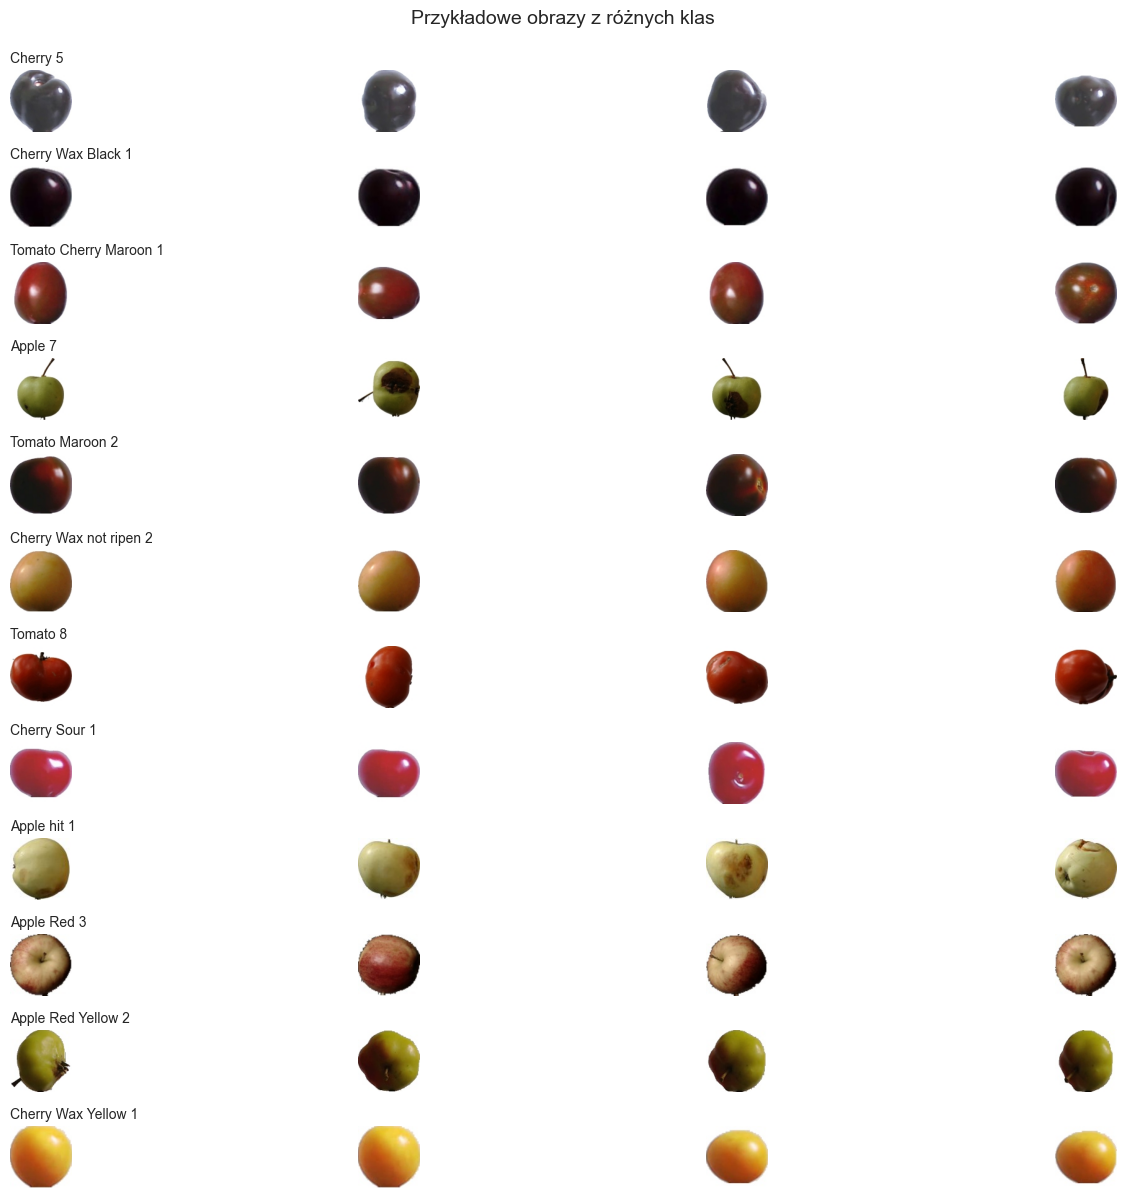

In [ ]:
# Wizualizacja przykładowych obrazów z różnych klas
# cv2.imread: https://docs.opencv.org/4.x/d4/da8/group__imgcodecs.html#ga288b8b3da0892bd651fce07b3bbd3a56
# cv2.cvtColor: https://docs.opencv.org/4.x/d8/d01/group__imgproc__color__conversions.html

# Funkcja do wizualizacji przykładowych obrazów z różnych klas
def show_sample_images(base_dir, n_classes=12, images_per_class=4, figsize=(16, 12)):
    """Pokazuje przykładowe obrazy z różnych klas"""
    
    if not base_dir.exists():
        print("⚠️ Katalog nie istnieje")
        return
    
    # Pobierz wszystkie klasy (zagnieżdżone podkatalogi)
    all_classes = []
    for category_dir in base_dir.iterdir():
        if category_dir.is_dir() and not category_dir.name.startswith('.'):
            for class_dir in category_dir.iterdir():
                if class_dir.is_dir() and not class_dir.name.startswith('.'):
                    all_classes.append(class_dir)
    
    # Losuj klasy
    selected_classes = np.random.choice(all_classes, min(n_classes, len(all_classes)), replace=False)
    
    fig, axes = plt.subplots(n_classes, images_per_class, figsize=figsize)
    
    for i, class_dir in enumerate(selected_classes):
        image_files = list(class_dir.glob('*.jpg'))
        
        # Losuj obrazy
        selected_images = np.random.choice(image_files, 
                                         min(images_per_class, len(image_files)), 
                                         replace=False)
        
        for j, img_path in enumerate(selected_images):
            img = cv2.imread(str(img_path))
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            axes[i, j].imshow(img_rgb)
            axes[i, j].axis('off')
            
            if j == 0:
                axes[i, j].set_title(class_dir.name, fontsize=10, loc='left')
    
    plt.suptitle('Przykładowe obrazy z różnych klas', fontsize=14, y=0.995)
    plt.tight_layout()
    plt.show()

# Pokaż przykłady
if TRAIN_DIR.exists():
    print("🖼️ Losowe przykłady z datasetu treningowego:")
    show_sample_images(TRAIN_DIR, n_classes=12, images_per_class=4)
else:
    print("⚠️ Dataset nie znaleziony")

## 5. Analiza jednego obrazu - preprocessing

📸 Analizowany obraz: r1_66_100.jpg
   Klasa: Apple 12


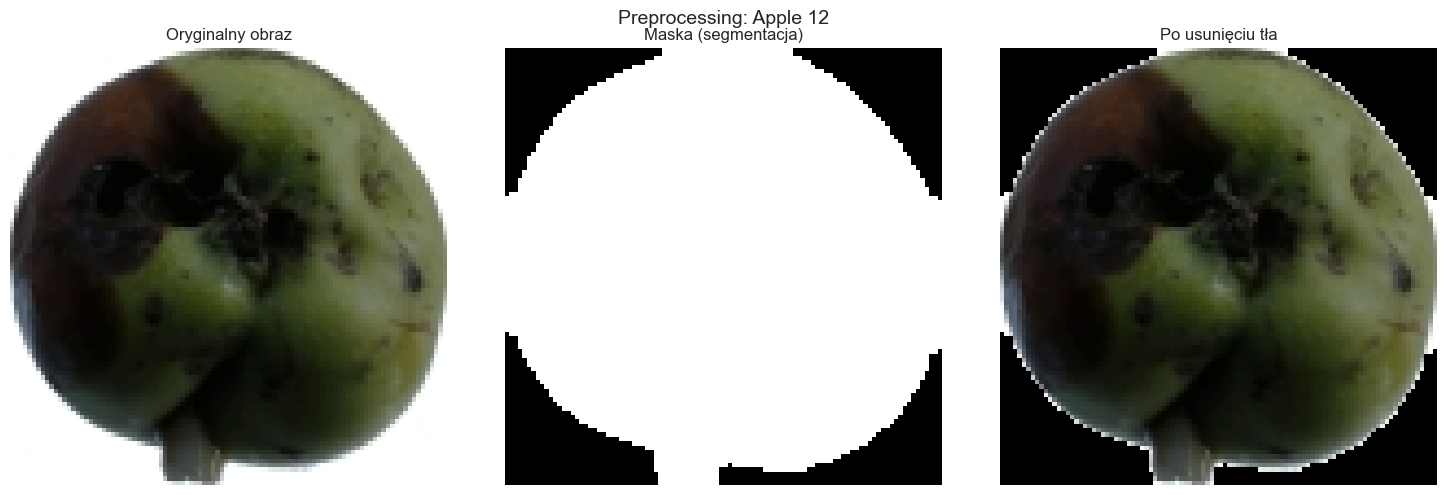


✓ Rozmiar obrazu: (100, 100, 3)
✓ Rozmiar maski: (100, 100)


In [ ]:
# Preprocessing - usuwanie białego tła (segmentacja)
# Moduł preprocessing zawiera funkcje do przetwarzania obrazów
# Segmentacja: https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html

# Import naszych modułów
from preprocessing import load_and_preprocess, remove_white_background

# Wybierz przykładowy obraz
if TRAIN_DIR.exists():
    # Znajdź pierwszy dostępny obraz (zagnieżdżone katalogi)
    example_image = None
    for category_dir in TRAIN_DIR.iterdir():
        if category_dir.is_dir() and not category_dir.name.startswith('.'):
            for class_dir in category_dir.iterdir():
                if class_dir.is_dir() and not class_dir.name.startswith('.'):
                    jpg_files = list(class_dir.glob('*.jpg'))
                    if jpg_files:
                        example_image = jpg_files[0]
                        example_class_name = class_dir.name
                        break
            if example_image:
                break
    
    if example_image:
        print(f"📸 Analizowany obraz: {example_image.name}")
        print(f"   Klasa: {example_class_name}")
        
        # Wczytaj oryginalny
        img_original = cv2.imread(str(example_image))
        img_original_rgb = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
        
        # Preprocessing
        img_no_bg, mask = remove_white_background(img_original)
        img_no_bg_rgb = cv2.cvtColor(img_no_bg, cv2.COLOR_BGR2RGB)
        
        # Wizualizacja
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        axes[0].imshow(img_original_rgb)
        axes[0].set_title('Oryginalny obraz')
        axes[0].axis('off')
        
        axes[1].imshow(mask, cmap='gray')
        axes[1].set_title('Maska (segmentacja)')
        axes[1].axis('off')
        
        axes[2].imshow(img_no_bg_rgb)
        axes[2].set_title('Po usunięciu tła')
        axes[2].axis('off')
        
        plt.suptitle(f'Preprocessing: {example_class_name}', fontsize=14)
        plt.tight_layout()
        plt.show()
        
        print(f"\n✓ Rozmiar obrazu: {img_original.shape}")
        print(f"✓ Rozmiar maski: {mask.shape}")
    else:
        print("⚠️ Nie znaleziono żadnych obrazów")
else:
    print("⚠️ Dataset nie znaleziony")

## 6. Lista wszystkich klas

Wyświetlenie wszystkich klas owoców i warzyw w datasecie.

In [12]:
# Wyświetl wszystkie klasy
if train_counts:
    all_classes = sorted(train_counts.keys())
    
    print(f"📋 Wszystkie {len(all_classes)} klas w datasecie:\n")
    
    # Wyświetl w kolumnach
    n_cols = 3
    n_rows = len(all_classes) // n_cols + (1 if len(all_classes) % n_cols else 0)
    
    for i in range(n_rows):
        row_classes = []
        for j in range(n_cols):
            idx = i + j * n_rows
            if idx < len(all_classes):
                row_classes.append(f"{idx+1:3d}. {all_classes[idx]:30s}")
        print("  ".join(row_classes))
else:
    print("⚠️ Brak danych")

📋 Wszystkie 48 klas w datasecie:

  1. Apple 11                         17. Apple Red 3                      33. Cherry Wax Yellow 1           
  2. Apple 12                         18. Apple Red Delicious 1            34. Cherry Wax not ripen 2        
  3. Apple 13                         19. Apple Red Yellow 2               35. Tomato 10                     
  4. Apple 14                         20. Apple Rotten 1                   36. Tomato 2                      
  5. Apple 17                         21. Apple hit 1                      37. Tomato 3                      
  6. Apple 18                         22. Apple worm 1                     38. Tomato 4                      
  7. Apple 5                          23. Cherry 1                         39. Tomato 5                      
  8. Apple 7                          24. Cherry 2                         40. Tomato 8                      
  9. Apple 8                          25. Cherry 4                         41. Tomato 

## 7. Zaawansowany Preprocessing

Różne techniki preprocessingu dla lepszego rozpoznawania owoców.

### 7.1 Histogramy kolorów

Histogramy rozkładu kolorów RGB i HSV - charakterystyczna sygnatura każdego owocu.

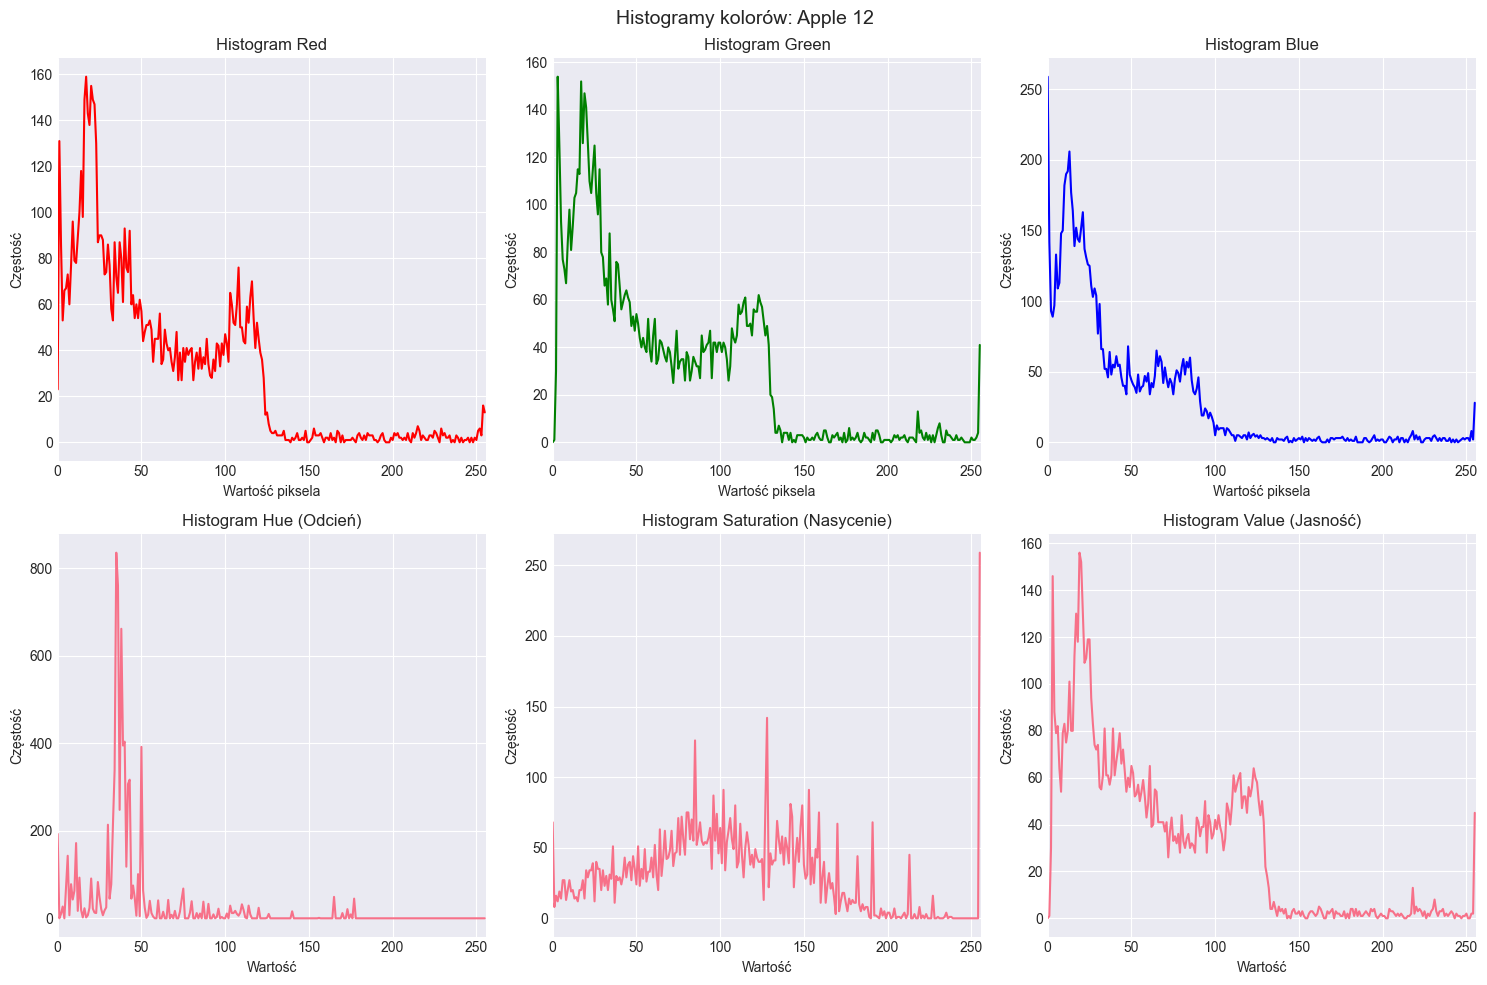

🎨 Statystyki kolorów dla Apple 12:
  Średni kolor RGB: R=56.2, G=59.6, B=41.5
  Średni kolor HSV: H=40.9°, S=103.6, V=61.1
  → Histogramy kolorów mogą być używane jako cechy do klasyfikacji!


In [ ]:
# Histogramy kolorów RGB i HSV
# cv2.calcHist: https://docs.opencv.org/4.x/d6/dc7/group__imgproc__hist.html#ga4b2b5fd75503ff9e6844cc4dcdaed35d
# Tutorial: https://docs.opencv.org/4.x/d1/db7/tutorial_py_histogram_begins.html
# Histogramy są charakterystyczną sygnaturą każdego owocu

# Histogramy kolorów
if TRAIN_DIR.exists() and example_image:
    img = cv2.imread(str(example_image))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # Usuń białe tło dla dokładniejszych histogramów
    img_no_bg, mask = remove_white_background(img)
    img_no_bg_rgb = cv2.cvtColor(img_no_bg, cv2.COLOR_BGR2RGB)
    
    # Oblicz histogramy RGB (tylko dla obszaru z obiektem)
    colors = ('r', 'g', 'b')
    color_names = ('Red', 'Green', 'Blue')
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # RGB histogramy
    for i, (color, name) in enumerate(zip(colors, color_names)):
        hist = cv2.calcHist([img_no_bg_rgb], [i], mask, [256], [0, 256])
        axes[0, i].plot(hist, color=color)
        axes[0, i].set_title(f'Histogram {name}')
        axes[0, i].set_xlabel('Wartość piksela')
        axes[0, i].set_ylabel('Częstość')
        axes[0, i].set_xlim([0, 256])
    
    # HSV histogramy
    hsv_names = ['Hue (Odcień)', 'Saturation (Nasycenie)', 'Value (Jasność)']
    hsv_colors = ['hsv', 'gray', 'gray']
    
    for i, (name, cmap) in enumerate(zip(hsv_names, hsv_colors)):
        hist = cv2.calcHist([img_hsv], [i], mask, [256], [0, 256])
        axes[1, i].plot(hist)
        axes[1, i].set_title(f'Histogram {name}')
        axes[1, i].set_xlabel('Wartość')
        axes[1, i].set_ylabel('Częstość')
        axes[1, i].set_xlim([0, 256])
    
    plt.suptitle(f'Histogramy kolorów: {example_class_name}', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Oblicz średnie kolory
    mean_color_rgb = cv2.mean(img_no_bg_rgb, mask=mask)[:3]
    mean_color_hsv = cv2.mean(img_hsv, mask=mask)[:3]
    
    print(f"🎨 Statystyki kolorów dla {example_class_name}:")
    print(f"  Średni kolor RGB: R={mean_color_rgb[0]:.1f}, G={mean_color_rgb[1]:.1f}, B={mean_color_rgb[2]:.1f}")
    print(f"  Średni kolor HSV: H={mean_color_hsv[0]:.1f}°, S={mean_color_hsv[1]:.1f}, V={mean_color_hsv[2]:.1f}")
    print("  → Histogramy kolorów mogą być używane jako cechy do klasyfikacji!")
else:
    print("⚠️ Brak obrazu do przetworzenia")

### 7.2 Poprawa jakości obrazu (CLAHE + Sharpening)

CLAHE poprawia kontrast lokalnie, sharpening wyostrza krawędzie.

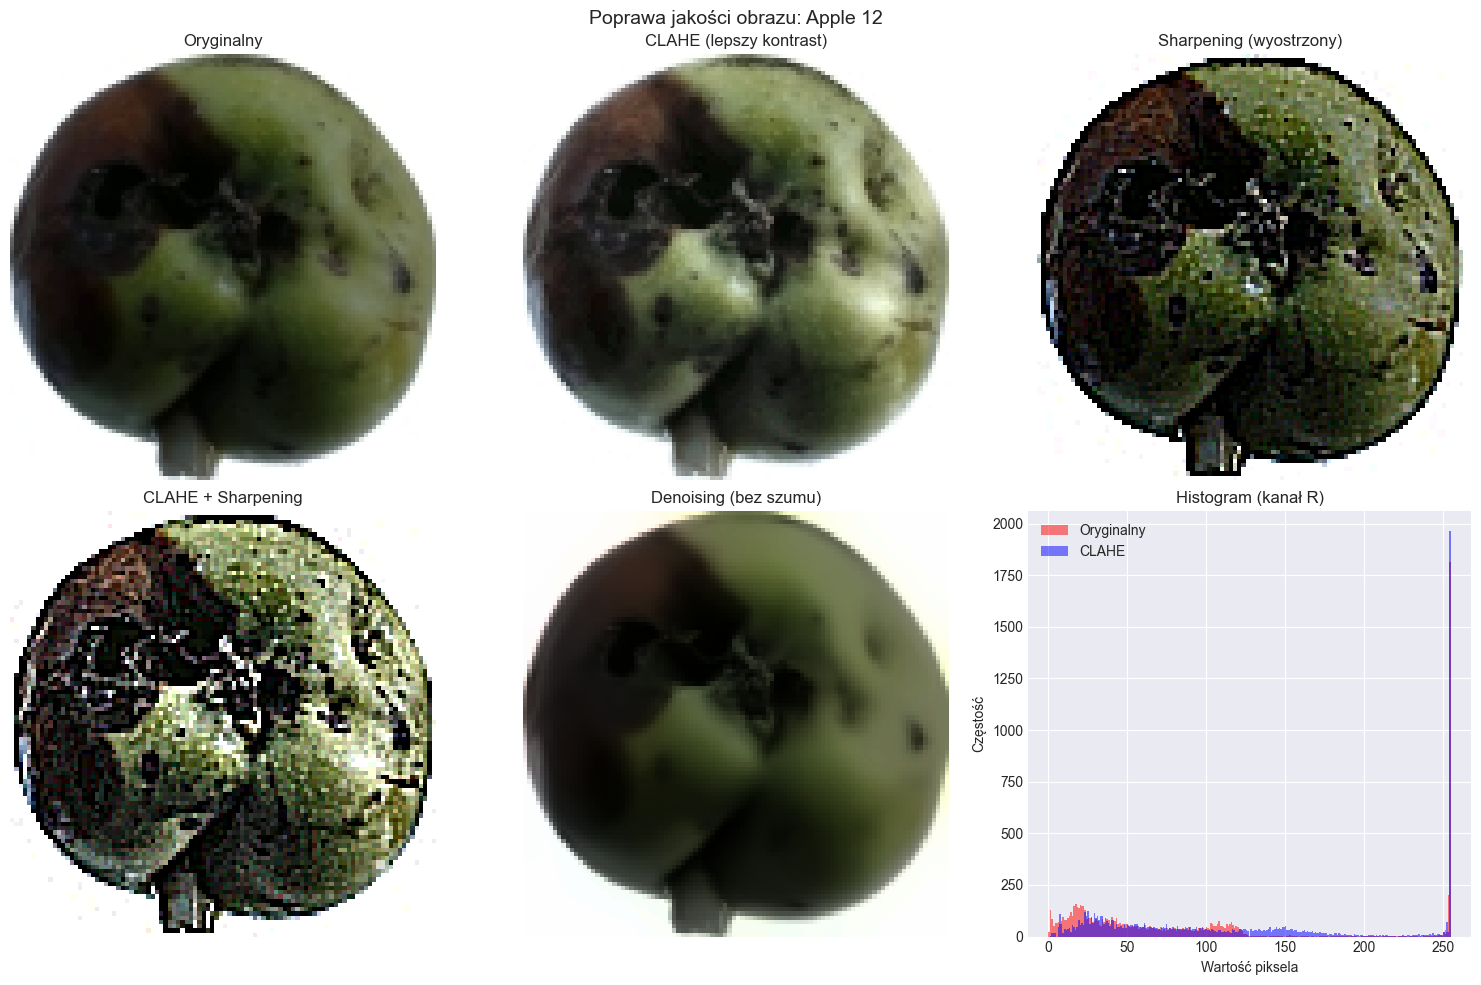

✓ Poprawa jakości wykonana
  CLAHE: poprawia kontrast lokalnie (adaptacyjnie)
  Sharpening: wyostrza krawędzie i detale
  Denoising: redukuje szum zachowując szczegóły


In [ ]:
# CLAHE (Contrast Limited Adaptive Histogram Equalization) + Sharpening
# cv2.createCLAHE: https://docs.opencv.org/4.x/d6/dc7/group__imgproc__hist.html#gad689d2607b7b3889453804f414ab1018
# Tutorial: https://docs.opencv.org/4.x/d5/daf/tutorial_py_histogram_equalization.html
# Paper: Pizer et al. (1987) - "Adaptive Histogram Equalization and Its Variations"
# CLAHE poprawia kontrast lokalnie, sharpening wyostrza krawędzie

# CLAHE i Sharpening
if TRAIN_DIR.exists() and example_image:
    img = cv2.imread(str(example_image))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # 1. CLAHE (Contrast Limited Adaptive Histogram Equalization)
    # Konwertuj do LAB, zastosuj CLAHE na kanale L
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    l_clahe = clahe.apply(l)
    
    lab_clahe = cv2.merge([l_clahe, a, b])
    img_clahe = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)
    img_clahe_rgb = cv2.cvtColor(img_clahe, cv2.COLOR_BGR2RGB)
    
    # 2. Sharpening (wyostrzanie)
    kernel_sharpen = np.array([[-1, -1, -1],
                               [-1,  9, -1],
                               [-1, -1, -1]])
    img_sharp = cv2.filter2D(img, -1, kernel_sharpen)
    img_sharp_rgb = cv2.cvtColor(img_sharp, cv2.COLOR_BGR2RGB)
    
    # 3. CLAHE + Sharpening
    img_combined = cv2.filter2D(img_clahe, -1, kernel_sharpen)
    img_combined_rgb = cv2.cvtColor(img_combined, cv2.COLOR_BGR2RGB)
    
    # 4. Denoising (usuwanie szumu)
    img_denoised = cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 21)
    img_denoised_rgb = cv2.cvtColor(img_denoised, cv2.COLOR_BGR2RGB)
    
    # Wizualizacja
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    axes[0, 0].imshow(img_rgb)
    axes[0, 0].set_title('Oryginalny')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(img_clahe_rgb)
    axes[0, 1].set_title('CLAHE (lepszy kontrast)')
    axes[0, 1].axis('off')
    
    axes[0, 2].imshow(img_sharp_rgb)
    axes[0, 2].set_title('Sharpening (wyostrzony)')
    axes[0, 2].axis('off')
    
    axes[1, 0].imshow(img_combined_rgb)
    axes[1, 0].set_title('CLAHE + Sharpening')
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(img_denoised_rgb)
    axes[1, 1].set_title('Denoising (bez szumu)')
    axes[1, 1].axis('off')
    
    # Porównanie histogramów
    axes[1, 2].hist(img_rgb[:,:,0].ravel(), bins=256, alpha=0.5, label='Oryginalny', color='red')
    axes[1, 2].hist(img_clahe_rgb[:,:,0].ravel(), bins=256, alpha=0.5, label='CLAHE', color='blue')
    axes[1, 2].set_title('Histogram (kanał R)')
    axes[1, 2].set_xlabel('Wartość piksela')
    axes[1, 2].set_ylabel('Częstość')
    axes[1, 2].legend()
    
    plt.suptitle(f'Poprawa jakości obrazu: {example_class_name}', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    print("✓ Poprawa jakości wykonana")
    print("  CLAHE: poprawia kontrast lokalnie (adaptacyjnie)")
    print("  Sharpening: wyostrza krawędzie i detale")
    print("  Denoising: redukuje szum zachowując szczegóły")
else:
    print("⚠️ Brak obrazu do przetworzenia")

### 7.3 Ekstrakcja cech tekstury (LBP)

Local Binary Patterns - wzory tekstury na powierzchni owoców.

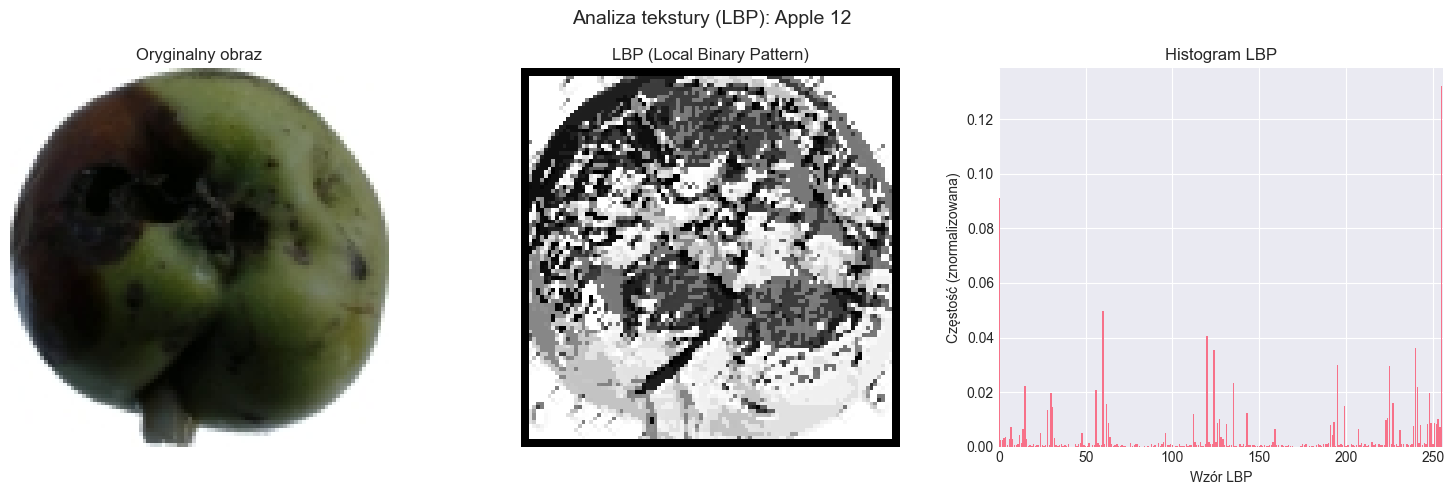

✓ LBP obliczone - histogram może być użyty jako cecha do klasyfikacji
  LBP shape: (100, 100)
  Histogram shape: (256,)


In [ ]:
# LBP - Local Binary Patterns (ekstrakcja cech tekstury)
# Paper: Ojala et al. (2002) - "Multiresolution Gray-Scale and Rotation Invariant Texture Classification with LBP"
# IEEE TPAMI: https://ieeexplore.ieee.org/document/1017623
# Tutorial: https://pyimagesearch.com/2015/12/07/local-binary-patterns-with-python-opencv/
# LBP wykrywa wzory tekstury na powierzchni owoców

# LBP - Local Binary Patterns
def compute_lbp(image, radius=1, n_points=8):
    """Oblicza Local Binary Pattern dla obrazu w skali szarości"""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image
    
    lbp = np.zeros_like(gray)
    
    for i in range(radius, gray.shape[0] - radius):
        for j in range(radius, gray.shape[1] - radius):
            center = gray[i, j]
            binary_string = ''
            
            # Porównaj z sąsiadami
            for angle in range(0, 360, 360 // n_points):
                x = i + int(radius * np.cos(np.deg2rad(angle)))
                y = j + int(radius * np.sin(np.deg2rad(angle)))
                
                if 0 <= x < gray.shape[0] and 0 <= y < gray.shape[1]:
                    binary_string += '1' if gray[x, y] >= center else '0'
            
            lbp[i, j] = int(binary_string, 2) if binary_string else 0
    
    return lbp

# Zastosuj LBP
if TRAIN_DIR.exists() and example_image:
    img = cv2.imread(str(example_image))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Oblicz LBP
    lbp = compute_lbp(img, radius=2, n_points=8)
    
    # Histogram LBP
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=256, range=(0, 256))
    lbp_hist = lbp_hist.astype('float')
    lbp_hist /= (lbp_hist.sum() + 1e-7)  # Normalizacja
    
    # Wizualizacja
    fig = plt.figure(figsize=(15, 5))
    
    gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 1])
    
    ax1 = fig.add_subplot(gs[0])
    ax1.imshow(img_rgb)
    ax1.set_title('Oryginalny obraz')
    ax1.axis('off')
    
    ax2 = fig.add_subplot(gs[1])
    ax2.imshow(lbp, cmap='gray')
    ax2.set_title('LBP (Local Binary Pattern)')
    ax2.axis('off')
    
    ax3 = fig.add_subplot(gs[2])
    ax3.bar(range(256), lbp_hist)
    ax3.set_title('Histogram LBP')
    ax3.set_xlabel('Wzór LBP')
    ax3.set_ylabel('Częstość (znormalizowana)')
    ax3.set_xlim([0, 256])
    
    plt.suptitle(f'Analiza tekstury (LBP): {example_class_name}', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    print("✓ LBP obliczone - histogram może być użyty jako cecha do klasyfikacji")
    print(f"  LBP shape: {lbp.shape}")
    print(f"  Histogram shape: {lbp_hist.shape}")
else:
    print("⚠️ Brak obrazu do przetworzenia")

### 7.4 Ekstrakcja cech kształtu

Owoce mają charakterystyczne kształty - okrągłe, owalne, wydłużone.

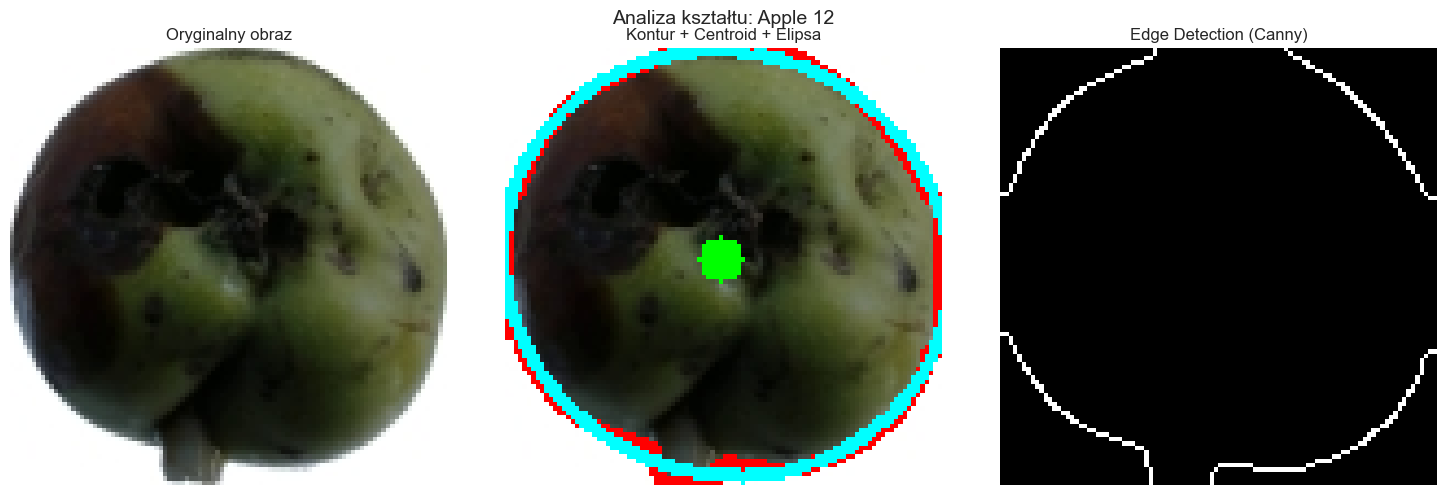

📐 Cechy kształtu dla Apple 12:
  Pole powierzchni: 7766 pikseli
  Obwód: 340.84 pikseli
  Okrągłość: 0.840 (1.0 = idealne koło)
  Ekscentryczność: 0.354 (0 = koło, ~1 = linia)
  Centroid: (49, 48)
  Hu Moments (pierwsze 3): [1.59749874e-01 7.23872007e-05 8.28884164e-06]


In [ ]:
# Ekstrakcja cech kształtu (kontury, momenty, Hu Moments)
# cv2.findContours: https://docs.opencv.org/4.x/d3/dc0/group__imgproc__shape.html#gadf1ad6a0b82947fa1fe3c3d497f260e0
# cv2.moments: https://docs.opencv.org/4.x/d3/dc0/group__imgproc__shape.html#ga556a180f43cab22649c23ada36a8a139
# Hu Moments Paper: Hu, M. K. (1962) - "Visual Pattern Recognition by Moment Invariants"
# Canny Edge: https://docs.opencv.org/4.x/da/d22/tutorial_py_canny.html

# Ekstrakcja cech kształtu
if TRAIN_DIR.exists() and example_image:
    img = cv2.imread(str(example_image))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Usuń białe tło (segmentacja)
    img_no_bg, mask = remove_white_background(img)
    
    # Znajdź kontury
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if contours:
        # Największy kontur (obiekt)
        largest_contour = max(contours, key=cv2.contourArea)
        
        # Oblicz cechy kształtu
        area = cv2.contourArea(largest_contour)
        perimeter = cv2.arcLength(largest_contour, True)
        
        # Momenty - opisują kształt
        moments = cv2.moments(largest_contour)
        if moments['m00'] != 0:
            cx = int(moments['m10'] / moments['m00'])
            cy = int(moments['m01'] / moments['m00'])
        else:
            cx, cy = 0, 0
        
        # Hu Moments - niezmiennicze względem skali/rotacji
        hu_moments = cv2.HuMoments(moments).flatten()
        
        # Okrągłość (circularity) - 1.0 = idealne koło
        circularity = 4 * np.pi * area / (perimeter ** 2) if perimeter > 0 else 0
        
        # Elipsa dopasowana
        if len(largest_contour) >= 5:
            ellipse = cv2.fitEllipse(largest_contour)
            (center, axes_len, angle) = ellipse
            major_axis = max(axes_len)
            minor_axis = min(axes_len)
            eccentricity = np.sqrt(1 - (minor_axis / major_axis) ** 2)
        else:
            ellipse = None
            eccentricity = 0
        
        # Wizualizacja
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Oryginalny
        axes[0].imshow(img_rgb)
        axes[0].set_title('Oryginalny obraz')
        axes[0].axis('off')
        
        # Kontur
        img_contour = img_rgb.copy()
        cv2.drawContours(img_contour, [largest_contour], -1, (255, 0, 0), 2)
        cv2.circle(img_contour, (cx, cy), 5, (0, 255, 0), -1)  # Centroid
        if ellipse:
            cv2.ellipse(img_contour, ellipse, (0, 255, 255), 2)
        
        axes[1].imshow(img_contour)
        axes[1].set_title('Kontur + Centroid + Elipsa')
        axes[1].axis('off')
        
        # Edge detection (Canny)
        edges = cv2.Canny(mask, 50, 150)
        axes[2].imshow(edges, cmap='gray')
        axes[2].set_title('Edge Detection (Canny)')
        axes[2].axis('off')
        
        plt.suptitle(f'Analiza kształtu: {example_class_name}', fontsize=14)
        plt.tight_layout()
        plt.show()
        
        # Wyświetl cechy
        print(f"📐 Cechy kształtu dla {example_class_name}:")
        print(f"  Pole powierzchni: {area:.0f} pikseli")
        print(f"  Obwód: {perimeter:.2f} pikseli")
        print(f"  Okrągłość: {circularity:.3f} (1.0 = idealne koło)")
        print(f"  Ekscentryczność: {eccentricity:.3f} (0 = koło, ~1 = linia)")
        print(f"  Centroid: ({cx}, {cy})")
        print(f"  Hu Moments (pierwsze 3): {hu_moments[:3]}")
    else:
        print("⚠️ Nie znaleziono konturów")
else:
    print("⚠️ Brak obrazu do przetworzenia")

### 7.5 Augmentacja danych

Zwiększamy różnorodność datasetu poprzez transformacje obrazów.

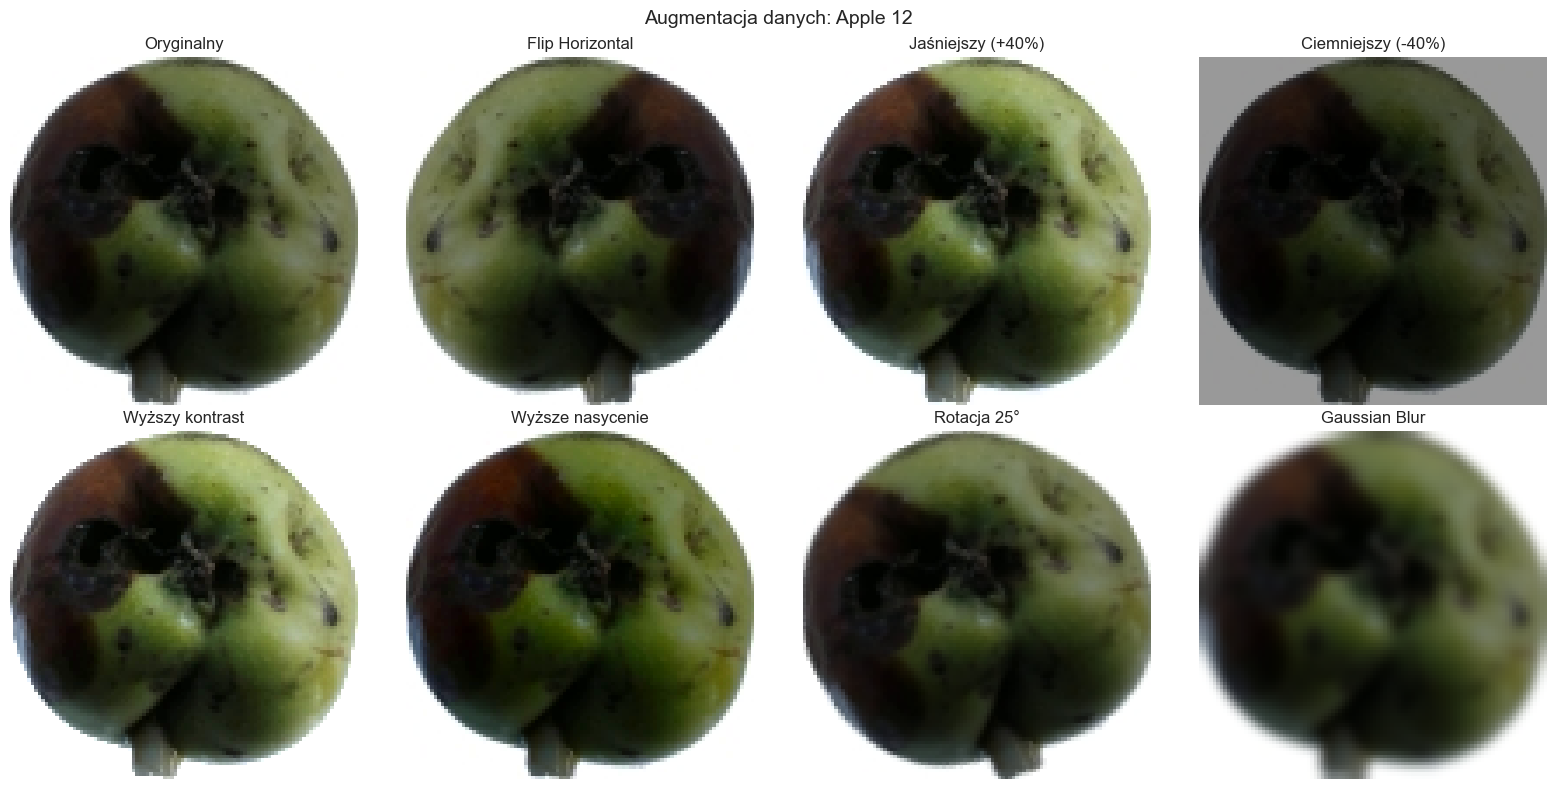

✓ Augmentacje wykonane - można użyć podczas treningu!


In [ ]:
# Data Augmentation (augmentacja danych) - zwiększanie różnorodności datasetu
# Paper: Shorten & Khoshgoftaar (2019) - "A survey on Image Data Augmentation for Deep Learning"
# Journal of Big Data: https://journalofbigdata.springeropen.com/articles/10.1186/s40537-019-0197-0
# cv2.flip: https://docs.opencv.org/4.x/d2/de8/group__core__array.html#gaca7be533e3dac7feb70fc60635adf441
# cv2.GaussianBlur: https://docs.opencv.org/4.x/d4/d86/group__imgproc__filter.html#gaabe8c836e97159a9193fb0b11ac52cf1

# Funkcje augmentacji
def augment_brightness(img, factor=1.3):
    """Zmiana jasności"""
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV).astype(np.float32)
    hsv[:,:,2] = np.clip(hsv[:,:,2] * factor, 0, 255)
    return cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2BGR)

def augment_contrast(img, alpha=1.5):
    """Zmiana kontrastu"""
    return cv2.convertScaleAbs(img, alpha=alpha, beta=0)

def augment_saturation(img, factor=1.5):
    """Zmiana nasycenia"""
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV).astype(np.float32)
    hsv[:,:,1] = np.clip(hsv[:,:,1] * factor, 0, 255)
    return cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2BGR)

def augment_rotation(img, angle=15):
    """Rotacja obrazu"""
    h, w = img.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(img, M, (w, h), borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))

def augment_blur(img, kernel_size=5):
    """Rozmycie gaussowskie"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

# Zastosuj augmentacje
if TRAIN_DIR.exists() and example_image:
    img = cv2.imread(str(example_image))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Różne augmentacje
    img_flip = cv2.flip(img, 1)  # Flip horizontal
    img_bright = augment_brightness(img, 1.4)
    img_dark = augment_brightness(img, 0.6)
    img_contrast = augment_contrast(img, 1.5)
    img_saturated = augment_saturation(img, 1.5)
    img_rotated = augment_rotation(img, 25)
    img_blur = augment_blur(img, 7)
    
    # Wizualizacja
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    
    images = [
        (img_rgb, 'Oryginalny'),
        (cv2.cvtColor(img_flip, cv2.COLOR_BGR2RGB), 'Flip Horizontal'),
        (cv2.cvtColor(img_bright, cv2.COLOR_BGR2RGB), 'Jaśniejszy (+40%)'),
        (cv2.cvtColor(img_dark, cv2.COLOR_BGR2RGB), 'Ciemniejszy (-40%)'),
        (cv2.cvtColor(img_contrast, cv2.COLOR_BGR2RGB), 'Wyższy kontrast'),
        (cv2.cvtColor(img_saturated, cv2.COLOR_BGR2RGB), 'Wyższe nasycenie'),
        (cv2.cvtColor(img_rotated, cv2.COLOR_BGR2RGB), 'Rotacja 25°'),
        (cv2.cvtColor(img_blur, cv2.COLOR_BGR2RGB), 'Gaussian Blur'),
    ]
    
    for idx, (img_aug, title) in enumerate(images):
        row = idx // 4
        col = idx % 4
        axes[row, col].imshow(img_aug)
        axes[row, col].set_title(title)
        axes[row, col].axis('off')
    
    plt.suptitle(f'Augmentacja danych: {example_class_name}', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    print("✓ Augmentacje wykonane - można użyć podczas treningu!")
else:
    print("⚠️ Brak obrazu do przetworzenia")

### 7.6 Transformacje przestrzeni kolorów

Kolory są kluczowe dla rozpoznawania owoców. HSV oddziela kolor od jasności, LAB lepiej oddaje percepcję człowieka.

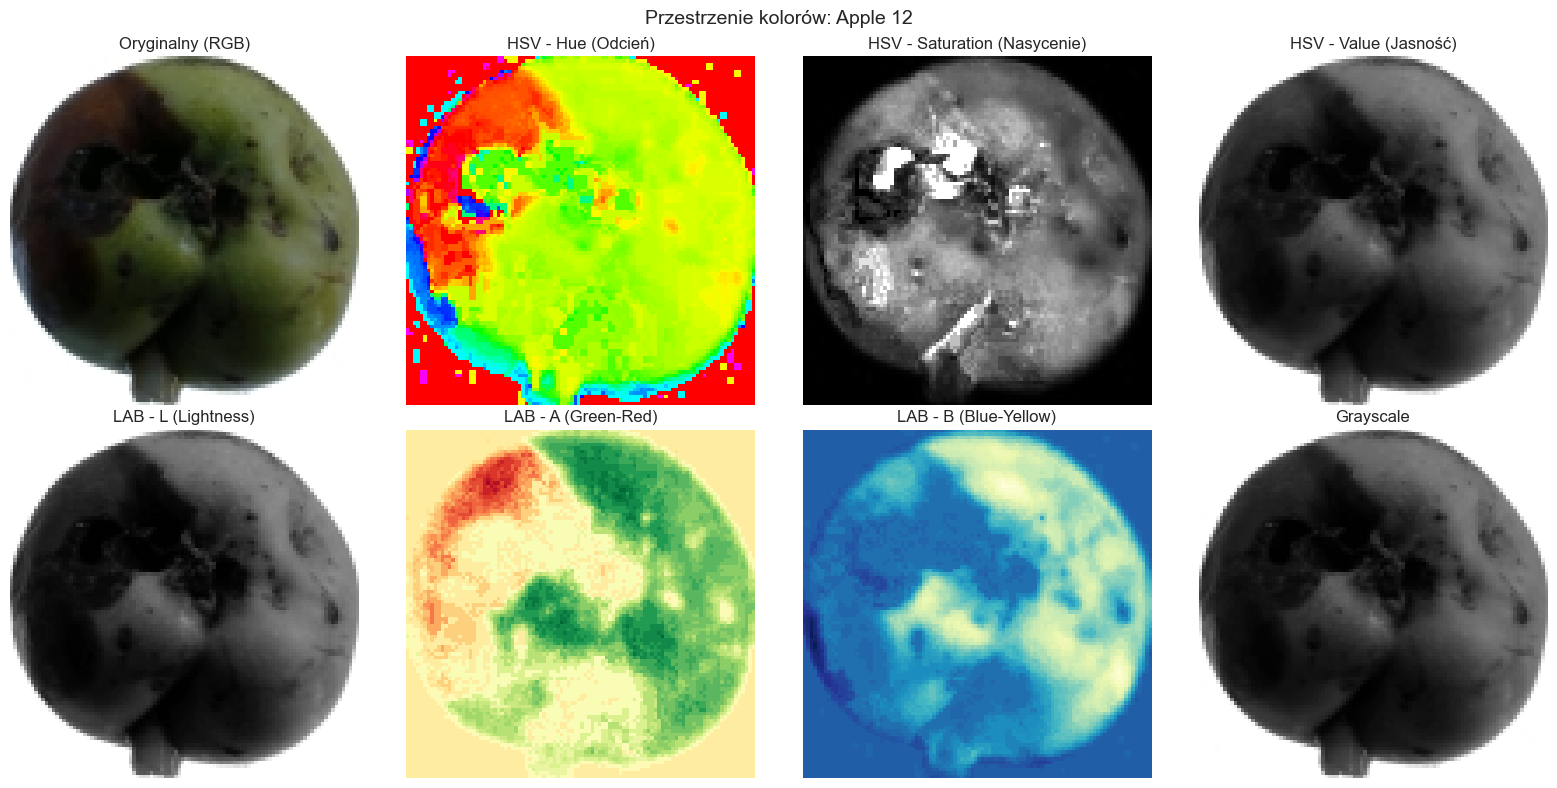

✓ Transformacje kolorów wykonane
  RGB shape: (100, 100, 3)
  HSV shape: (100, 100, 3)
  LAB shape: (100, 100, 3)


In [ ]:
# Przestrzenie kolorów (RGB, HSV, LAB, Grayscale)
# Color conversions: https://docs.opencv.org/4.x/de/d25/imgproc_color_conversions.html
# HSV Tutorial: https://docs.opencv.org/4.x/df/d9d/tutorial_py_colorspaces.html
# LAB Color Space (CIE 1976): https://en.wikipedia.org/wiki/CIELAB_color_space
# HSV oddziela kolor od jasności, LAB lepiej oddaje percepcję człowieka

# Wczytaj przykładowy obraz
if TRAIN_DIR.exists() and example_image:
    img = cv2.imread(str(example_image))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Transformacje przestrzeni kolorów
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Wizualizacja
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    
    # RGB
    axes[0, 0].imshow(img_rgb)
    axes[0, 0].set_title('Oryginalny (RGB)')
    axes[0, 0].axis('off')
    
    # HSV kanały
    axes[0, 1].imshow(img_hsv[:,:,0], cmap='hsv')
    axes[0, 1].set_title('HSV - Hue (Odcień)')
    axes[0, 1].axis('off')
    
    axes[0, 2].imshow(img_hsv[:,:,1], cmap='gray')
    axes[0, 2].set_title('HSV - Saturation (Nasycenie)')
    axes[0, 2].axis('off')
    
    axes[0, 3].imshow(img_hsv[:,:,2], cmap='gray')
    axes[0, 3].set_title('HSV - Value (Jasność)')
    axes[0, 3].axis('off')
    
    # LAB kanały
    axes[1, 0].imshow(img_lab[:,:,0], cmap='gray')
    axes[1, 0].set_title('LAB - L (Lightness)')
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(img_lab[:,:,1], cmap='RdYlGn_r')
    axes[1, 1].set_title('LAB - A (Green-Red)')
    axes[1, 1].axis('off')
    
    axes[1, 2].imshow(img_lab[:,:,2], cmap='YlGnBu_r')
    axes[1, 2].set_title('LAB - B (Blue-Yellow)')
    axes[1, 2].axis('off')
    
    # Grayscale
    axes[1, 3].imshow(img_gray, cmap='gray')
    axes[1, 3].set_title('Grayscale')
    axes[1, 3].axis('off')
    
    plt.suptitle(f'Przestrzenie kolorów: {example_class_name}', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    print("✓ Transformacje kolorów wykonane")
    print(f"  RGB shape: {img_rgb.shape}")
    print(f"  HSV shape: {img_hsv.shape}")
    print(f"  LAB shape: {img_lab.shape}")
else:
    print("⚠️ Brak obrazu do przetworzenia")